In [ ]:
!wget https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper_funcs.py
!wget https://media.githubusercontent.com/media/mufaddalhamidofficial/skimlit_ai/main/data.zip

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub
import io

In [ ]:
tf.__version__

In [3]:
unzip_data("data.zip", '/kaggle/temp/')
!rm -rf data.zip

In [ ]:
DIR_NAME_01 = "/kaggle/temp/data/01_percent"
DIR_NAME_1 = "/kaggle/temp/data/1_percent"
DIR_NAME_10 = "/kaggle/temp/data/10_percent"
DIR_NAME_100 = "/kaggle/temp/data/100_percent"

test_df_100 = pd.read_csv(DIR_NAME_100 + "/test.csv")
test_df_100 = test_df_100.iloc[:, 1:]

test_sentences_ = test_df_100.text.to_numpy()
test_labels_ = test_df_100.target.to_numpy()

## Callbacks:

In [ ]:
def get_callbacks(experiment_name, use_early_stopping = True, patience=10, use_tensorboard = True, use_model_checkpoint = True):
    callbacks = [
    ]
    if use_tensorboard:
        callbacks.append(
            create_tensorboard_callback(
                dir_name="skim_lit/tensorboard",
                experiment_name=experiment_name,
            )
        )
    if use_model_checkpoint:
        callbacks.append(
            create_checkpoint_callback(
                dir_name="skim_lit/checkpoint",
                experiment_name=experiment_name,
                monitor="val_accuracy",
            )
        )
    if use_early_stopping:
        
        callbacks.append(tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            restore_best_weights=True,
        ))
    return callbacks

# Modelling

## Model s Data Preps:

### Get and Prepare data

In [ ]:
train_data_1 = pd.read_csv(DIR_NAME_1 + "/train.csv")
train_sentences = train_data_1.text.to_numpy()
train_labels = train_data_1.target.to_numpy()

val_data_1 = pd.read_csv(DIR_NAME_1 + "/val.csv")
val_sentences = val_data_1.text.to_numpy()
val_labels = val_data_1.target.to_numpy()

test_sentences = test_sentences_.copy()
test_labels = test_labels_.copy()

### One hot encode labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1, 1))

train_labels_one_hot

In [ ]:
class_names = one_hot_encoder.categories_[0]
classes_count = len(class_names) # type: ignore
class_names

In [ ]:
import string

train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

char_lens = [len(sentence.split(' ')) for sentence in train_chars]

seq_char_len = int(np.percentile(char_lens, 90))

alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2
seq_char_len, NUM_CHAR_TOKENS, alphabet

## Model s 13 + s 16

### Model s 13

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_data_1["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_data_1["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df_100["line_number"].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_data_1["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_data_1["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df_100["total_lines"].to_numpy(), depth=20)

train_line_numbers_one_hot.shape, train_total_lines_one_hot.shape

In [ ]:
train_word_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_line_numbers_one_hot, train_total_lines_one_hot))
train_word_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_word_pos_data, train_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_word_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_line_numbers_one_hot, val_total_lines_one_hot))
val_word_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_word_pos_data, val_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_word_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_line_numbers_one_hot, test_total_lines_one_hot))
test_word_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_word_pos_data, test_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:

hub_embedding = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
    trainable=False,
    name="universal_sentence_encoder",
)


token_inputs = tf.keras.layers.Input(shape=[], dtype='string', name='token_inputs')
token_embedding = hub_embedding(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_lines_inputs = tf.keras.layers.Input(shape=(20,), name='total_lines_inputs')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

final_concatenate = tf.keras.layers.Concatenate(name='final_concatenate')([token_model.output, line_number_model.output, total_lines_model.output])

outputs = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(final_concatenate)

model_s_13 = tf.keras.Model([token_model.input, line_number_model.input, total_lines_model.input], outputs)

model_s_13.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_s_13_history = model_s_13.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=int(len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(len(val_dataset)),
    callbacks=get_callbacks("model_s_13"),
)

model_s_13.load_weights("skim_lit/checkpoint/model_s_13/checkpoint.ckpt")

model_s_13_val_preds = tf.argmax(model_s_13.predict(val_dataset), axis=1)
model_s_13_val_results = calculate_results(tf.argmax(val_labels_one_hot, axis=1), model_s_13_val_preds)
print(model_s_13_val_results)

plot_loss_curves(model_s_13_history)

model_s_13_preds = tf.argmax(model_s_13.predict(test_dataset), axis=1)
model_s_13_results = calculate_results(tf.argmax(test_labels_one_hot, axis=1), model_s_13_preds)
print(model_s_13_results)

### Model s 16

In [ ]:
import string

train_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in train_sentences]
val_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in val_sentences]
test_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in test_sentences]

sentence_lengths = [len(sentence.split(' ')) for sentence in train_chars_puntuations]
# sentence_lengths
seq_char_punctuation_len = int(np.percentile(sentence_lengths, 95) / 4) * 4

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    output_sequence_length=seq_char_punctuation_len,
    standardize='lower',
)

char_vectorizer.adapt(train_chars_puntuations)

train_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(train_chars_puntuations)))
val_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(val_chars_puntuations)))
test_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(test_chars_puntuations)))

one_hot_matrix = np.eye(len(char_vectorizer.get_vocabulary()))

train_chars_puntuations_one_hot = one_hot_matrix[train_chars_puntuations_vectorized][:, :, 2:]
val_chars_puntuations_one_hot = one_hot_matrix[val_chars_puntuations_vectorized][:, :, 2:]
test_chars_puntuations_one_hot = one_hot_matrix[test_chars_puntuations_vectorized][:, :, 2:]
train_chars_puntuations_one_hot.shape, val_chars_puntuations_one_hot.shape, test_chars_puntuations_one_hot.shape

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_data_1["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_data_1["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df_100["line_number"].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_data_1["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_data_1["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df_100["total_lines"].to_numpy(), depth=20)

train_line_numbers_one_hot.shape, train_total_lines_one_hot.shape

In [ ]:
train_word_char_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars_puntuations_one_hot, train_line_numbers_one_hot, train_total_lines_one_hot))
train_word_char_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_word_char_pos_data, train_word_char_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_word_char_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars_puntuations_one_hot, val_line_numbers_one_hot, val_total_lines_one_hot))
val_word_char_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_word_char_pos_data, val_word_char_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_word_char_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars_puntuations_one_hot, test_line_numbers_one_hot, test_total_lines_one_hot))
test_word_char_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_word_char_pos_data, test_word_char_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
hub_embedding = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
    trainable=False,
    name="universal_sentence_encoder",
)


token_inputs = tf.keras.layers.Input(shape=[], dtype='string', name='token_inputs')
token_embedding = hub_embedding(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = tf.keras.layers.Input(shape=(20,26,), dtype=tf.float32, name='char_puntuation_inputs')
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_inputs)
char_outputs = tf.keras.layers.Dense(128, activation='relu')(char_bi_lstm)
char_model = tf.keras.Model(char_inputs, char_outputs)

line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_lines_inputs = tf.keras.layers.Input(shape=(20,), name='total_lines_inputs')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

token_char_concatenate = tf.keras.layers.Concatenate(name="token_char_concatenate")([token_model.output, char_model.output])

drop_out = tf.keras.layers.Dense(256, activation='relu')(token_char_concatenate)
drop_out = tf.keras.layers.Dropout(0.5)(drop_out)

final_concatenate = tf.keras.layers.Concatenate(name='final_concatenate')([drop_out, line_number_model.output, total_lines_model.output])

outputs = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(final_concatenate)

model_s_16 = tf.keras.Model([token_model.input, char_model.input, line_number_model.input, total_lines_model.input], outputs)

model_s_16.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_s_16_history = model_s_16.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=int(len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(len(val_dataset)),
    callbacks=get_callbacks("model_s_16"),
)

model_s_16.load_weights("skim_lit/checkpoint/model_s_16/checkpoint.ckpt")

model_s_16_val_preds = tf.argmax(model_s_16.predict(val_dataset), axis=1)
model_s_16_val_results = calculate_results(tf.argmax(val_labels_one_hot, axis=1), model_s_16_val_preds)
print(model_s_16_val_results)

plot_loss_curves(model_s_16_history)

model_s_16_preds = tf.argmax(model_s_16.predict(test_dataset), axis=1)
model_s_16_results = calculate_results(tf.argmax(test_labels_one_hot, axis=1), model_s_16_preds)
print(model_s_16_results)

### Merging them

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_data_1["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_data_1["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df_100["line_number"].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_data_1["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_data_1["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df_100["total_lines"].to_numpy(), depth=20)

train_line_numbers_one_hot.shape, train_total_lines_one_hot.shape

(TensorShape([22084, 15]), TensorShape([22084, 20]))

In [ ]:
import string

train_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in train_sentences]
val_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in val_sentences]
test_chars_puntuations = [' '.join([e for e in list(sentence) if e not in string.ascii_lowercase + ' ']) for sentence in test_sentences]

sentence_lengths = [len(sentence.split(' ')) for sentence in train_chars_puntuations]
# sentence_lengths
seq_char_punctuation_len = int(np.percentile(sentence_lengths, 95) / 4) * 4

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    output_sequence_length=seq_char_punctuation_len,
    standardize='lower',
)

char_vectorizer.adapt(train_chars_puntuations)

train_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(train_chars_puntuations)))
val_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(val_chars_puntuations)))
test_chars_puntuations_vectorized = np.array(char_vectorizer(np.array(test_chars_puntuations)))

one_hot_matrix = np.eye(len(char_vectorizer.get_vocabulary()))

train_chars_puntuations_one_hot = one_hot_matrix[train_chars_puntuations_vectorized][:, :, 2:]
val_chars_puntuations_one_hot = one_hot_matrix[val_chars_puntuations_vectorized][:, :, 2:]
test_chars_puntuations_one_hot = one_hot_matrix[test_chars_puntuations_vectorized][:, :, 2:]
train_chars_puntuations_one_hot.shape, val_chars_puntuations_one_hot.shape, test_chars_puntuations_one_hot.shape

((22084, 20, 26), (272, 20, 26), (29493, 20, 26))

In [ ]:
train_word_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_line_numbers_one_hot, train_total_lines_one_hot))
train_word_char_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars_puntuations_one_hot, train_line_numbers_one_hot, train_total_lines_one_hot))
train_merged_data= tf.data.Dataset.from_tensor_slices((train_sentences, train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars_puntuations_one_hot, train_line_numbers_one_hot, train_total_lines_one_hot))
train_word_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_merged_data, train_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_word_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_line_numbers_one_hot, val_total_lines_one_hot))
val_word_char_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars_puntuations_one_hot, val_line_numbers_one_hot, val_total_lines_one_hot))
val_merged_data= tf.data.Dataset.from_tensor_slices((val_sentences, val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars_puntuations_one_hot, val_line_numbers_one_hot, val_total_lines_one_hot))
val_word_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_merged_data, val_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_word_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_line_numbers_one_hot, test_total_lines_one_hot))
test_word_char_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars_puntuations_one_hot, test_line_numbers_one_hot, test_total_lines_one_hot))
test_merged_data= tf.data.Dataset.from_tensor_slices((test_sentences, test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars_puntuations_one_hot, test_line_numbers_one_hot, test_total_lines_one_hot))
test_word_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_merged_data, test_word_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
for layer in model_s_16.layers:
    layer._name = layer.name + '_16'
    
for layer in model_s_13.layers:
    layer._name = layer.name + '_13'

In [ ]:
model_s_13.trainable = False
model_s_16.trainable = False

concate_13_16 = tf.keras.layers.Concatenate(name="concate_13_16")([model_s_13.output, model_s_16.output])
concate_13_16 = tf.keras.layers.Dense(256, activation='relu')(concate_13_16)
concate_13_16 = tf.keras.layers.Dense(5, activation='softmax')(concate_13_16)

model_s_13_16_model = tf.keras.Model([model_s_13.input, model_s_16.input], concate_13_16)

model_s_13_16_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)


history_s_13_16 = model_s_13_16_model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=len(train_dataset),
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=get_callbacks("model_s_13_16"),
)

model_s_13_16_model.load_weights("skim_lit/checkpoint/model_s_13_16/checkpoint.ckpt")

model_s_13_16_val_preds = tf.argmax(model_s_13_16_model.predict(val_dataset), axis=1)
model_s_13_16_val_results = calculate_results(tf.argmax(val_labels_one_hot, axis=1), model_s_13_16_val_preds)
print(model_s_13_16_val_results)

plot_loss_curves(history_s_13_16)

model_s_13_16_model_preds = tf.argmax(model_s_13_16_model.predict(test_dataset), axis=1)
model_s_13_16_model_results = calculate_results(tf.argmax(test_labels_one_hot, axis=1), model_s_13_16_model_preds)
print(model_s_13_16_model_results)

python(7052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


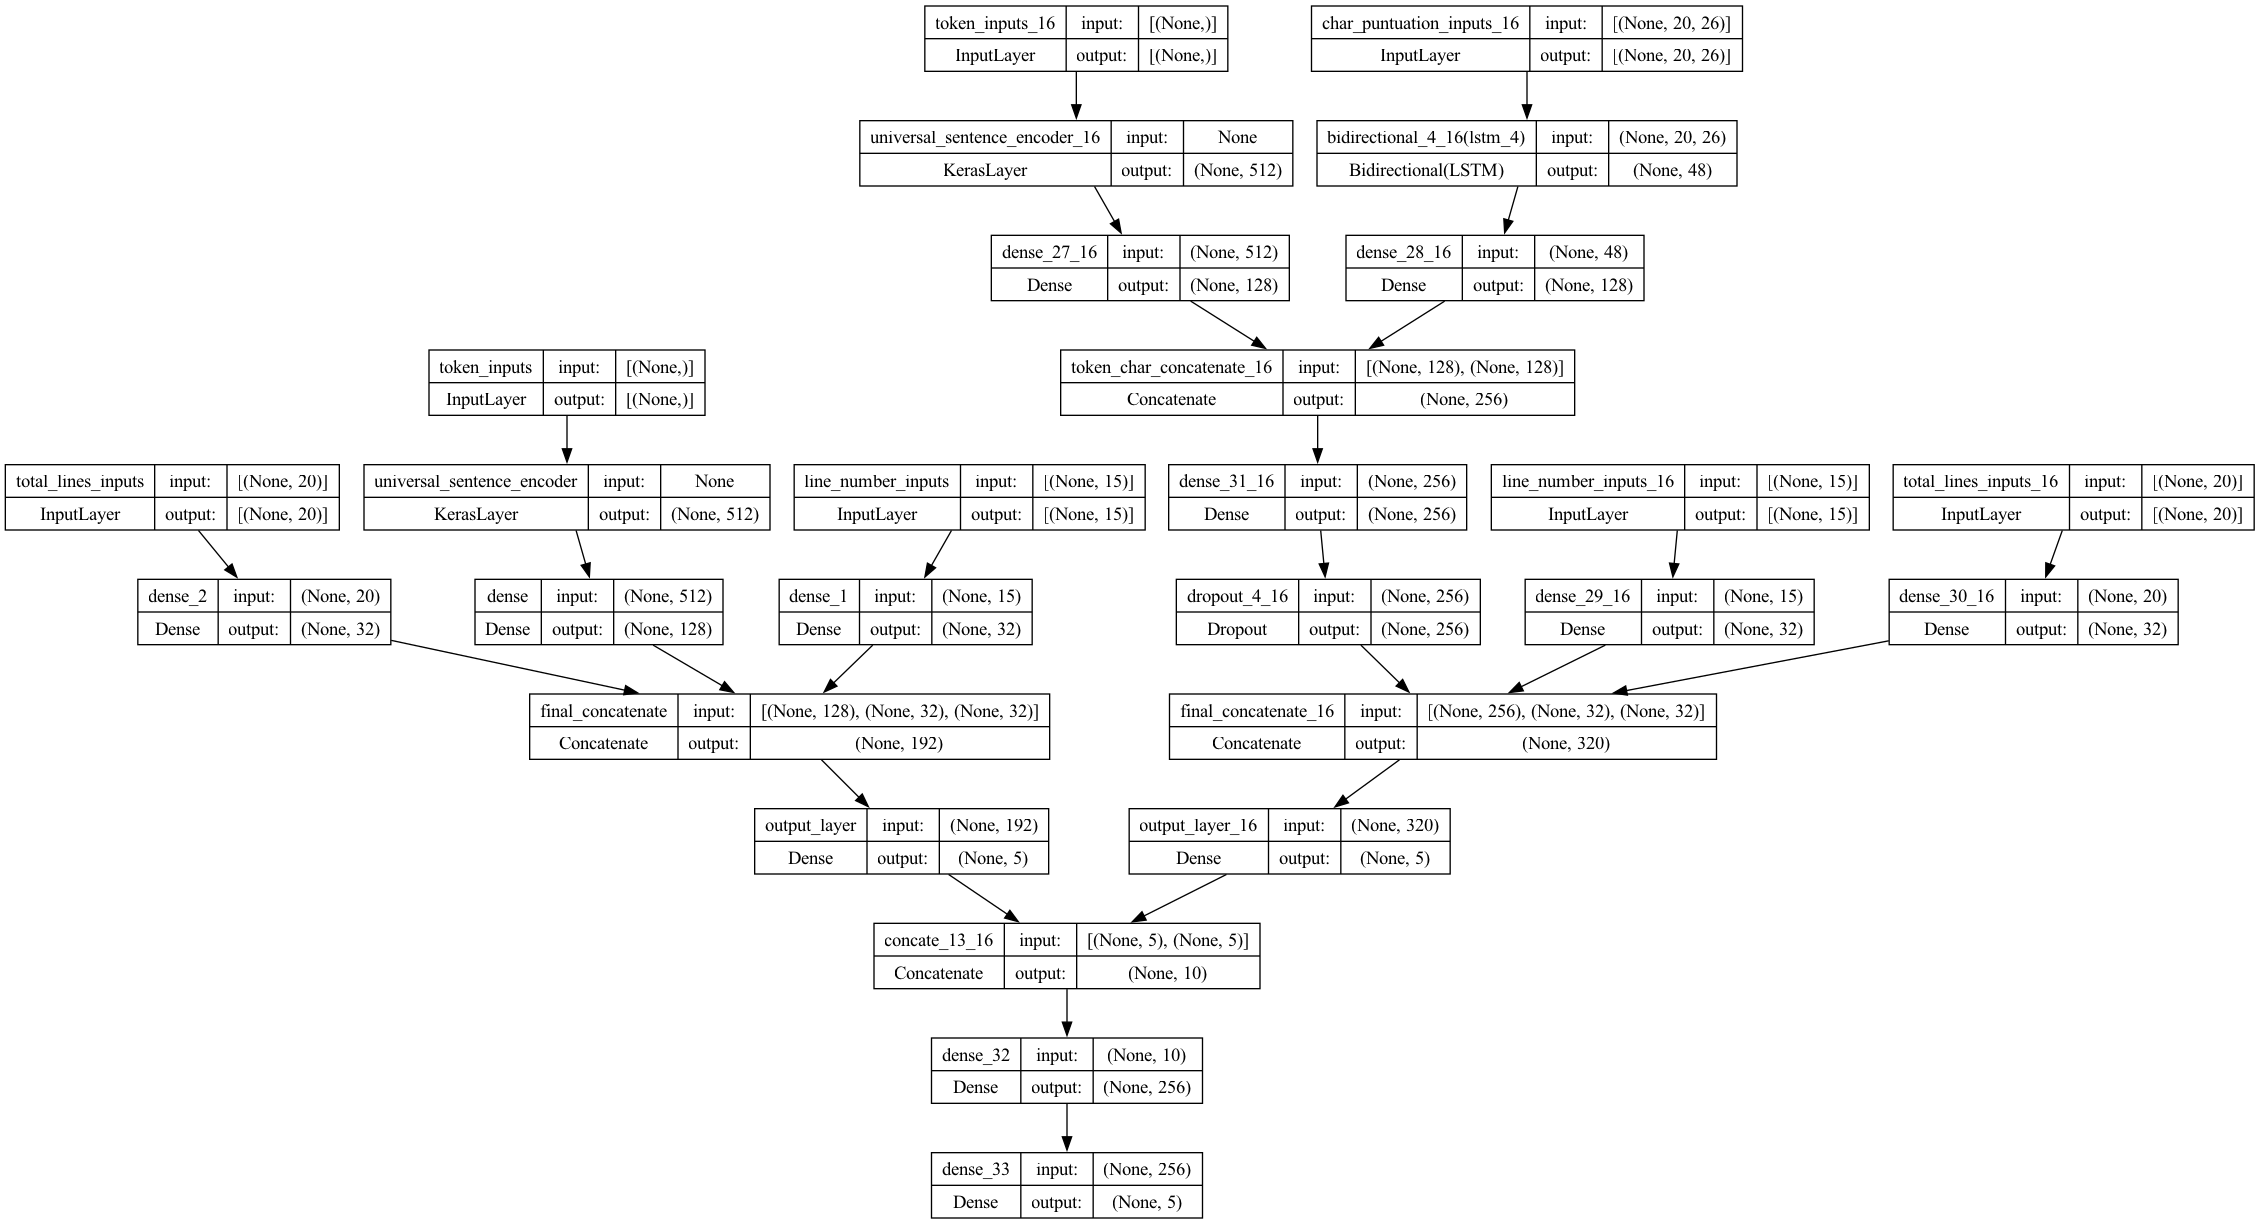

In [ ]:
tf.keras.utils.plot_model(model_s_13_16_model, show_shapes=True)